# Project 4: Web Scraping Indeed.com & Predicting Salaries

In Project 4, we practice two major skills: collecting data via  web scraping and building a binary predictor with Logistic Regression.

We will collect salary information on data science jobs in a variety of markets. Using location, title, and job summary, we'll predict the salary of the job. For job posting sites, this is extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), extrapolating expected salary can help guide negotiations.

Normally, we can use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Q: Why would we want this to be a classification problem?
- A: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Section one focuses on scraping Indeed.com; then we use listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

Scrape job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries. First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract.

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [49]:
URL = 'http://www.indeed.com/jobs?q=data+scientist+$20,000&l=New+York&start=10'

In [227]:
import numpy as np
import pandas as pd
import math

In [51]:
import requests
import bs4
from bs4 import BeautifulSoup

In [110]:
# Extend the visibility in Jupyter notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [52]:
# read site in soup
r = requests.get(URL)
soup = BeautifulSoup(r.content, "lxml")

# Append to the full set of results
results = soup.findAll('div', { "class" : "result" })


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some of the more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```

- Make sure these functions are robust and can handle cases where the data/field may not be available
- Test the functions on the results above

In [53]:
# get text
def extract_text(el):
    if el:
        return el.text.strip()
    else:
        return ''
        
# company
def get_company_from_result(result):
    return extract_text(result.find('span', {'class' : 'company'}))

# location
def get_location_from_result(result):
    return extract_text(result.find('span', {'class' : 'location'}))

# summary
def get_summary_from_result(result):
    return extract_text(result.find('span', {'class' : 'summary'}))

# title
def get_title_from_result(result):
    return extract_text(result.find('a', {'data-tn-element' : 'jobTitle'}))

# get salary if exists
def get_salary_from_result(result):
    salary_table = result.find('td', {'class' : 'snip'})
    if salary_table:
        snip = salary_table.find('nobr')
        if snip:
            return snip.text.strip()   
    return None

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results: the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try different city). The second controls where in the results to start and gives 10 results (so we can keep incrementing this by 10 to move further within the list).

#### Complete the following code to collect results from multiple cities and start points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [127]:
# create template URL and max number of results (pages) to pull
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"

cities = ['Atlanta','San+Jose','San+Francisco','Los+Angeles','Seattle','New+York','Dallas','Chicago','Boston','silicon+valley']


# for loop to pull data with bs4
for city in cities:
    for start in range(0,2000,10):
        r = requests.get(url_template.format(city, start))
        # Grab the results from the request (as above)
        soup = BeautifulSoup(r.content, "lxml")
        # Append to the full set of results
        results += soup.findAll('div', { "class" : "result" })

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [128]:
df = pd.DataFrame()

for result in results:
    company_ = get_company_from_result(result)
    location_ = get_location_from_result(result)
    summary_ = get_summary_from_result(result)
    title_ = get_title_from_result(result)
    salary_ = get_salary_from_result(result)
    
    df= df.append({"Company":company_,"Location":location_,"Summary":summary_,"Title":title_,"Salary":salary_},ignore_index=True)
    
df.head()

,Company,Location,Salary,Summary,Title
0,Aetna,"New York, NY 10017",None,We are currently looking for an exceptional Se...,Senior Data Scientist Manager
1,Indeed,"New York, NY 10036",None,Work closely with stakeholders on the data dem...,Data Engineer
2,WorkFusion,"New York, NY",None,We are looking for a data scientist to join ou...,Deep Learning Data Scientist
3,PulsePoint,"New York, NY",None,"3+ Years as a Data Scientist, preferable in th...",Sr. Data Scientist
4,AIG,"New York, NY",None,AIG is seeking world-class dynamic Data Scient...,Senior Investments Data Scientist


Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [129]:
print df.shape

(78792, 5)


In [130]:
df.drop_duplicates(inplace=True)
df.shape

(7224, 5)

In [132]:
print "The number of null values in the Salary column is: ",df["Salary"].isnull().sum()," out of ",df.shape[0]

The number of null values in the Salary column is:  6771  out of  7224


In [133]:
df_no_salary = df[df["Salary"].isnull()].copy()
df_no_salary.head()

,Company,Location,Salary,Summary,Title
0,Aetna,"New York, NY 10017",None,We are currently looking for an exceptional Se...,Senior Data Scientist Manager
1,Indeed,"New York, NY 10036",None,Work closely with stakeholders on the data dem...,Data Engineer
2,WorkFusion,"New York, NY",None,We are looking for a data scientist to join ou...,Deep Learning Data Scientist
3,PulsePoint,"New York, NY",None,"3+ Years as a Data Scientist, preferable in th...",Sr. Data Scientist
4,AIG,"New York, NY",None,AIG is seeking world-class dynamic Data Scient...,Senior Investments Data Scientist


In [134]:
df.dropna(inplace=True)

In [135]:
df.shape

(453, 5)

In [136]:
df["Salary"].value_counts()

$120,000 a year               10
$180,000 a year                8
$150,000 - $180,000 a year     8
$140,000 a year                7
$200,000 a year                7
$100,000 a year                7
$150,000 - $200,000 a year     6
$120,000 - $150,000 a year     6
$150,000 - $170,000 a year     6
$160,000 a year                6
$59,708 - $72,246 a year       6
$110,000 a year                5
$68,239 - $85,644 a year       5
$140,000 - $160,000 a year     5
$130,000 a year                5
$50,000 a year                 5
$70,286 - $88,213 a year       5
$100,000 - $120,000 a year     5
$150,000 a year                5
$170,000 a year                4
$30 an hour                    4
$140,000 - $180,000 a year     4
$120,000 - $160,000 a year     4
$88,305 - $114,802 a year      3
$75,000 - $90,000 a year       3
$80,000 - $120,000 a year      3
$4,495 - $6,433 a month        3
$3,077 - $4,113 a month        3
$90,000 - $140,000 a year      3
$110,000 - $140,000 a year     3
$120,000 -

In [137]:
df2 = df.copy()

In [138]:
# Filter out salary entries referring to week, hour or month
df = df[~(df.Salary.astype('str').str.contains('hour'))]
df = df[~(df.Salary.astype('str').str.contains('day'))]
df = df[~(df.Salary.astype('str').str.contains('month'))]
df = df[~(df.Salary.astype('str').str.contains('week'))]
print df["Salary"].isnull().sum()

0


In [139]:
df["Salary"].value_counts()

$120,000 a year               10
$180,000 a year                8
$150,000 - $180,000 a year     8
$200,000 a year                7
$100,000 a year                7
$140,000 a year                7
$120,000 - $150,000 a year     6
$160,000 a year                6
$150,000 - $200,000 a year     6
$150,000 - $170,000 a year     6
$59,708 - $72,246 a year       6
$70,286 - $88,213 a year       5
$130,000 a year                5
$68,239 - $85,644 a year       5
$50,000 a year                 5
$110,000 a year                5
$100,000 - $120,000 a year     5
$150,000 a year                5
$140,000 - $160,000 a year     5
$140,000 - $180,000 a year     4
$120,000 - $160,000 a year     4
$170,000 a year                4
$75,000 - $90,000 a year       3
$110,000 - $140,000 a year     3
$88,305 - $114,802 a year      3
$75,000 - $100,000 a year      3
$80,000 a year                 3
$80,000 - $120,000 a year      3
$70,000 - $90,000 a year       3
$90,000 - $140,000 a year      3
$80,000 - 

In [141]:
df.shape

(345, 5)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [142]:
import re
import numpy as np
def extract_salary_average(salary_string):
    regex = r'\$([0-9]+,[0-9]+)'
    matches = re.findall(regex, salary_string)
    return np.mean([float(salary.replace(',', '')) for salary in matches ])

In [143]:
# use '.map' to transform salary to new feature
df['Salary_avg'] = map(extract_salary_average,df["Salary"])
df.head()

,Company,Location,Salary,Summary,Title,Salary_avg
7,Oliver James Associates,"New York, NY","$165,000 a year",3+ years of exposure working with Predictive m...,Program Manager - Data Science - New York City...,165000.0
22,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","As a Behavioral Scientist you will:. Collects,...",Behavioral Scientist,101553.5
24,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","Applying principles, theories and methodology ...",Statistician (Health),101553.5
37,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab),85500.0
83,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist,80000.0


In [144]:
# Now, we will split the location to city and state
loc_vector = df["Location"].str.split(",")
loc_vector

7                                          [New York,  NY]
22                                          [Atlanta,  GA]
24                                          [Atlanta,  GA]
37                                          [Atlanta,  GA]
83             [Atlanta,  GA 30308 (Old Fourth Ward area)]
85                                          [Atlanta,  GA]
141                                         [Atlanta,  GA]
159                                         [Atlanta,  GA]
169                                         [Atlanta,  GA]
217                                         [Atlanta,  GA]
306                                         [Atlanta,  GA]
311                                   [Atlanta,  GA 30341]
319                                         [Atlanta,  GA]
1509                                       [San Jose,  CA]
1529                                       [Campbell,  CA]
1557                                      [Palo Alto,  CA]
1565                                      [Palo Alto,  C

In [153]:
city_vector = []
state_vector = []
for tup in loc_vector:
    city_vector.append(tup[0])
    state_vector.append(tup[1])

In [154]:
df['City'] = city_vector
df['State'] = state_vector

df.head()

,Company,Location,Salary,Summary,Title,Salary_avg,City,State
7,Oliver James Associates,"New York, NY","$165,000 a year",3+ years of exposure working with Predictive m...,Program Manager - Data Science - New York City...,165000.0,New York,NY
22,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","As a Behavioral Scientist you will:. Collects,...",Behavioral Scientist,101553.5,Atlanta,GA
24,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","Applying principles, theories and methodology ...",Statistician (Health),101553.5,Atlanta,GA
37,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab),85500.0,Atlanta,GA
83,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist,80000.0,Atlanta,GA 30308 (Old Fourth Ward area)


In [160]:
df['State'] = df['State'].str.strip()

In [161]:
df["State"] = df["State"].apply(lambda x: x[0:2])
df["State"].value_counts()

CA    114
NY    105
MA     48
IL     32
GA     18
WA     16
TX      7
NJ      5
Name: State, dtype: int64

In [162]:
df.head()

,Company,Location,Salary,Summary,Title,Salary_avg,City,State
7,Oliver James Associates,"New York, NY","$165,000 a year",3+ years of exposure working with Predictive m...,Program Manager - Data Science - New York City...,165000.0,New York,NY
22,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","As a Behavioral Scientist you will:. Collects,...",Behavioral Scientist,101553.5,Atlanta,GA
24,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","Applying principles, theories and methodology ...",Statistician (Health),101553.5,Atlanta,GA
37,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab),85500.0,Atlanta,GA
83,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist,80000.0,Atlanta,GA


In [168]:
# save scraped results as a CSV for Tableau/external viz
df.to_csv('assets/Jobs.csv', encoding= 'utf-8')

## Predicting salaries using Logistic Regression

In [171]:
# load in the the data of scraped salaries
jobs = pd.read_csv('assets/Jobs.csv')
jobs.head()

,Unnamed: 0,Company,Location,Salary,Summary,Title,Salary_avg,City,State
0,7,Oliver James Associates,"New York, NY","$165,000 a year",3+ years of exposure working with Predictive m...,Program Manager - Data Science - New York City...,165000.0,New York,NY
1,22,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","As a Behavioral Scientist you will:. Collects,...",Behavioral Scientist,101553.5,Atlanta,GA
2,24,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","Applying principles, theories and methodology ...",Statistician (Health),101553.5,Atlanta,GA
3,37,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab),85500.0,Atlanta,GA
4,83,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist,80000.0,Atlanta,GA


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [176]:
# calculate median and create feature with 1 as high salary
median_salary = jobs['Salary_avg'].median()

jobs['Salary_bin'] = jobs['Salary_avg'].apply(lambda x: 1 if x>=median_salary else 0)

jobs.head()

,Unnamed: 0,Company,Location,Salary,Summary,Title,Salary_avg,City,State,Salary_bin
0,7,Oliver James Associates,"New York, NY","$165,000 a year",3+ years of exposure working with Predictive m...,Program Manager - Data Science - New York City...,165000.0,New York,NY,1
1,22,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","As a Behavioral Scientist you will:. Collects,...",Behavioral Scientist,101553.5,Atlanta,GA,0
2,24,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year","Applying principles, theories and methodology ...",Statistician (Health),101553.5,Atlanta,GA,0
3,37,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab),85500.0,Atlanta,GA,0
4,83,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist,80000.0,Atlanta,GA,0


### Q: What is the baseline accuracy for this model?

It is 50% if we guess randomly, half the salaries will be below the median and half will be above.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [178]:
# create statsmodel and summary
import statsmodels.formula.api as sm

In [238]:
model = sm.logit("Salary_bin ~ City+State", data=jobs).fit(method = 'ncg')
model.summary()

Optimization terminated successfully.
         Current function value: 0.452981
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 30
         Hessian evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Salary_bin   No. Observations:                  345
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                           49
Date:                Tue, 22 Nov 2016   Pseudo R-squ.:                  0.3465
Time:                        08:39:31   Log-Likelihood:                -156.28
converged:                       True   LL-Null:                       -239.12
                                        LLR p-value:                 1.387e-14
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -2.4775   6.84e+06  -3.62e-07      1.000     -1.34e+07  1.34e+07
City[T.Andover]             -5.7191        nan        nan        nan           nan       nan
City[T.Atlanta]              9.0335    250.690      0.036      0.971      -482.310   500.377
City[T.Bedford]             -5.7191        nan        nan        nan           nan       nan
City[T.Bellevue]             3.5660        nan        nan        nan           nan       nan
City[T.Berkeley]             2.4775   6.84e+06   3.62e-07      1.000     -1.34e+07  1.34e+07
City[T.Boston]               6.8077        nan        nan        nan           nan       nan
City[T.Brisbane]            14.3958   6.84e+06    2.1e-06      1.000     -1.34e+07  1.34e+07
City[T.Burbank]             -9.4512   6.84e+06  -1.38e-06      1.000     -1.34e+07  1.34e+07
City[T.Cambridge]            5.4860        nan        nan        nan           nan       nan
City[T.Campbell]             2.4775   6.84e+06   3.62e-07      1.000     -1.34e+07  1.34e+07
City[T.Chatsworth]          -9.4512   6.84e+06  -1.38e-06      1.000     -1.34e+07  1.34e+07
City[T.Chicago]              6.6355        nan        nan        nan           nan       nan
City[T.Culver City]          2.4775   6.84e+06   3.62e-07      1.000     -1.34e+07  1.34e+07
City[T.Cypress]             -9.4512   6.84e+06  -1.38e-06      1.000     -1.34e+07  1.34e+07
City[T.Dallas]               6.5914   5.82e+07   1.13e-07      1.000     -1.14e+08  1.14e+08
City[T.Emeryville]          -9.4512   6.84e+06  -1.38e-06      1.000     -1.34e+07  1.34e+07
City[T.Evanston]            -5.5309        nan        nan        nan           nan       nan
City[T.Framingham]          -5.7191        nan        nan        nan           nan       nan
City[T.Glenview]            -5.5309        nan        nan        nan           nan       nan
City[T.Hoboken]             -2.0920   4.86e+10  -4.31e-11      1.000     -9.52e+10  9.52e+10
City[T.Irving]              -6.2458   5.82e+07  -1.07e-07      1.000     -1.14e+08  1.14e+08
City[T.Kenilworth]          -2.0920   4.86e+10  -4.31e-11      1.000     -9.52e+10  9.52e+10
City[T.Long Island City]    -4.6848   3.21e+06  -1.46e-06      1.000     -6.29e+06  6.29e+06
City[T.Los Angeles]          1.4479   6.84e+06   2.12e-07      1.000     -1.34e+07  1.34e+07
City[T.Lowell]              17.6261        nan        nan        nan           nan       nan
City[T.Manhattan]           -6.5380   3.21e+06  -2.04e-06      1.000     -6.29e+06  6.29e+06
City[T.Maynard]             -5.7191        nan        nan        nan           nan       nan
City[T.Menlo Park]           2.4775   6.84e+06   3.62e-07      1.000     -1.34e+07  1.34e+07
City[T.Milpitas]            13.7027   6.84e+06      2e-06      1.000     -1.34e+07  1.34e+07
City[T.Mountain View]       14.3958   6.84e+06    2.1e-06      1.000     -1.34e+07  1.34e+07
City[T.New York]             9.0137   3.21e+06   2.81e-06      1.000     -6.29e

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' or 'Manager' is in the title 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [183]:
# create senior, director, and manager dummies
jobs['is_senior'] = jobs['Title'].str.contains('Senior').astype(int)
jobs['is_manager'] = jobs['Title'].str.contains('Manager').astype(int)
jobs['data'] = jobs['Title'].str.contains('Data').astype(int)
jobs['is_analyst'] = jobs['Title'].str.contains('Analyst').astype(int)
jobs['quantitative'] = jobs['Title'].str.contains('Quantitative').astype(int)
jobs['machine'] = jobs['Title'].str.contains('Machine').astype(int)
jobs['is_scientist'] = jobs['Title'].str.contains('Scientist').astype(int)
jobs['is_lead'] = jobs['Title'].str.contains('Lead').astype(int)

In [214]:
model = sm.logit("Salary_bin ~ State+City + is_lead + is_scientist + machine + quantitative + is_analyst + data + is_manager + is_senior", data=jobs).fit(method = 'ncg')
model.summary()

Optimization terminated successfully.
         Current function value: 0.325006
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 30
         Hessian evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Salary_bin   No. Observations:                  345
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                           57
Date:                Mon, 21 Nov 2016   Pseudo R-squ.:                  0.5311
Time:                        20:19:55   Log-Likelihood:                -112.13
converged:                       True   LL-Null:                       -239.12
                                        LLR p-value:                 1.114e-26
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -2.5121   6.01e+06  -4.18e-07      1.000     -1.18e+07  1.18e+07
State[T.GA]                -10.3552   6.01e+06  -1.72e-06      1.000     -1.18e+07  1.18e+07
State[T.IL]                 -3.9723   1.07e+08  -3.71e-08      1.000      -2.1e+08   2.1e+08
State[T.MA]                 -4.2422        nan        nan        nan           nan       nan
State[T.NJ]                 -9.5132        nan        nan        nan           nan       nan
State[T.NY]                 -6.5702        nan        nan        nan           nan       nan
State[T.TX]                 -6.1589        nan        nan        nan           nan       nan
State[T.WA]                 -1.5271   6.13e+07  -2.49e-08      1.000      -1.2e+08   1.2e+08
City[T.Andover]             -5.5597        nan        nan        nan           nan       nan
City[T.Atlanta]              9.0088    331.549      0.027      0.978      -640.815   658.833
City[T.Bedford]             -5.9530        nan        nan        nan           nan       nan
City[T.Bellevue]             2.8676   6.05e+07   4.74e-08      1.000     -1.19e+08  1.19e+08
City[T.Berkeley]             3.3175   6.01e+06   5.52e-07      1.000     -1.18e+07  1.18e+07
City[T.Boston]               6.4491        nan        nan        nan           nan       nan
City[T.Brisbane]            13.4800   6.01e+06   2.24e-06      1.000     -1.18e+07  1.18e+07
City[T.Burbank]            -11.8479   6.01e+06  -1.97e-06      1.000     -1.18e+07  1.18e+07
City[T.Cambridge]            4.4741        nan        nan        nan           nan       nan
City[T.Campbell]             1.5316   6.01e+06   2.55e-07      1.000     -1.18e+07  1.18e+07
City[T.Chatsworth]          -4.1910   6.01e+06  -6.97e-07      1.000     -1.18e+07  1.18e+07
City[T.Chicago]              5.1446   1.05e+08   4.88e-08      1.000     -2.06e+08  2.06e+08
City[T.Culver City]          0.7035   6.01e+06   1.17e-07      1.000     -1.18e+07  1.18e+07
City[T.Cypress]             -8.6868   6.01e+06  -1.44e-06      1.000     -1.18e+07  1.18e+07
City[T.Dallas]               5.4890        nan        nan        nan           nan       nan
City[T.Emeryville]          -9.8874   6.01e+06  -1.64e-06      1.000     -1.18e+07  1.18e+07
City[T.Evanston]            -1.0661   1.05e+08  -1.01e-08      1.000     -2.06e+08  2.06e+08
City[T.Framingham]          -7.6003        nan        nan        nan           nan       nan
City[T.Glenview]            -8.0508   1.05e+08  -7.64e-08      1.000     -2.06e+08  2.06e+08
City[T.Hoboken]             -2.0343        nan        nan        nan           nan       nan
City[T.Irving]              -7.6962        nan        nan        nan           nan       nan
City[T.Kenilworth]          -1.7000        nan        nan        nan           nan       nan
City[T.Long Island City]    -4.1549        nan        nan        nan           nan       nan
City[T.Los Angeles]          0.8962   6.01e+06   1.49e-07      1.000     -1.18e

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [198]:
# scale, (patsy optional), and fit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
plt.style.use('seaborn-white')
%matplotlib inline

In [189]:
X = dmatrix('~C(City) + C(State)+is_lead + is_scientist + machine + quantitative + is_analyst + data + is_manager + is_senior', data = jobs)
y = jobs['Salary_bin'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, stratify = y,random_state=77)


logreg = LogisticRegression(random_state=77)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

In [190]:
logreg.coef_

array([[-0.26903244, -0.16793339, -0.84074125, -0.18586819,  0.34214172,
         0.17416575,  0.72771773,  0.38381836,  0.        , -0.20388116,
         0.        , -0.11907346,  0.07308802, -0.24370624, -0.19368285,
         0.11067992,  0.        ,  0.        , -0.38199388, -0.47544213,
        -0.17608479, -0.65829431,  0.        , -0.2636278 , -0.1309576 ,
         0.        , -1.06179835, -0.18586819, -0.30158732,  0.40889768,
         0.        ,  0.85661932, -0.49759894, -0.18093528,  0.89368193,
        -0.28528155, -0.27750318, -0.28620574,  0.81144324, -0.17206925,
        -0.36760178, -0.44871882,  1.62848502,  1.11659167,  0.89519299,
        -0.14549989,  0.50761224, -0.25273492, -0.35534015,  0.        ,
        -1.17987889, -0.40235411, -0.75316723, -0.82896812, -0.64974211,
        -0.71968363, -0.08956391,  0.70388268, -0.14120263,  1.36811424,
         2.26906779, -1.34425028,  1.19213616, -0.69453381,  0.26659173]])

In [193]:
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['High Salary', 'Low Salary'],columns=['predicted_high','predicted_low'])

print(confusion)

             predicted_high  predicted_low
High Salary              45             12
Low Salary               13             44


In [199]:
print classification_report(Y_test, Y_pred)

             precision    recall  f1-score   support

          0       0.79      0.77      0.78        57
          1       0.78      0.79      0.78        57

avg / total       0.78      0.78      0.78       114



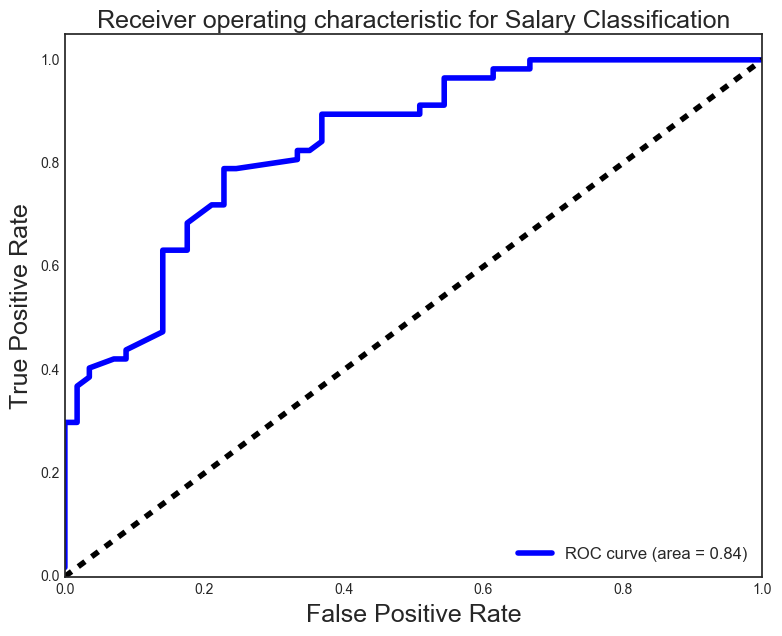

In [196]:
Y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 ("High Salary")
plt.figure(figsize=[9,7])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Salary Classification', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

Accuracy is the number of correct guesses divided by all of the guesses. We have correctly predicted 45 job offers to have 'high' salaries and 44 job offers to have 'low' salaries. We have incorrectly labeled 13 'low' salaries to be 'high, and 12 'high' salaries to be 'low'. The accuracy of our model, therefore, is 89/114 or 0.78

Precision is the ratio of correctly identified 'high' salary job offers to the number of total job offers labeled as 'high' in our model. For this model, precision is 0.78 or 78% of our guesses for 'high' values were True

Recall is the number of correctly identified 'high' values in proportion to the the total number of 'high' values. With a value of 0.79 for our model, this means we have correctly identified 79% of all the 'high' values

Whereas accuracy takes the correct guesses for both cases and evaluates how we did overall, precision looks only at one class and looks to identify how well we have performed for that specific class ('high' or 'low'). Recall aims at evaluating how likely our model is to identify the instances of one of the classes

We want our model to have higher precision when it is important to avoid False Positives, or avoid labeling 'low' salaries as 'high' in our case.
On the other hand, we would like our model to have a higher recall if it is important to identify as many 'high' salaries as possible, even if that means incorrectly identifying many more 'low' salaries as 'high'

In [200]:
from sklearn.cross_validation import cross_val_score

In [201]:
scores = cross_val_score(logreg, X, y, cv= 5)
print scores

[ 0.85714286  0.63768116  0.85507246  0.62318841  0.76470588]


### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [220]:
model1 = LogisticRegression(penalty = 'l1', C=1.0)

model1.fit(X_train, Y_train)
Y_pred = model1.predict(X_test)
model1.coef_

array([[-0.29232545,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.78847963,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.50363789,  0.        ,  0.        ,  0.        ,
         0.        ,  0.39628169,  0.        ,  0.        ,  1.0535205 ,
         0.        ,  0.        ,  0.        ,  0.72765145,  0.        ,
         0.        ,  0.        ,  2.09283889,  1.33734366,  0.86178709,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.84005798, -0.02604682, -0.61524281, -0.65969474,  0.        ,
        -0.65666885,  0.        ,  0.48223352, -0.01488076,  1.71431601,
         3.18781926, -1.88960471,  1.26416659, -0.51224245,  0.        ]])

In [221]:
model2 = LogisticRegression(penalty = 'l2', C=1.0)

model2.fit(X_train, Y_train)
Y_pred = model2.predict(X_test)
model2.coef_

array([[-0.26903244, -0.16793339, -0.84074125, -0.18586819,  0.34214172,
         0.17416575,  0.72771773,  0.38381836,  0.        , -0.20388116,
         0.        , -0.11907346,  0.07308802, -0.24370624, -0.19368285,
         0.11067992,  0.        ,  0.        , -0.38199388, -0.47544213,
        -0.17608479, -0.65829431,  0.        , -0.2636278 , -0.1309576 ,
         0.        , -1.06179835, -0.18586819, -0.30158732,  0.40889768,
         0.        ,  0.85661932, -0.49759894, -0.18093528,  0.89368193,
        -0.28528155, -0.27750318, -0.28620574,  0.81144324, -0.17206925,
        -0.36760178, -0.44871882,  1.62848502,  1.11659167,  0.89519299,
        -0.14549989,  0.50761224, -0.25273492, -0.35534015,  0.        ,
        -1.17987889, -0.40235411, -0.75316723, -0.82896812, -0.64974211,
        -0.71968363, -0.08956391,  0.70388268, -0.14120263,  1.36811424,
         2.26906779, -1.34425028,  1.19213616, -0.69453381,  0.26659173]])

In [234]:
np.exp(model1.coef_)

array([[  0.74652554,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   2.20004899,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   0.22231991,   1.        ,
          1.        ,   1.        ,   1.        ,   1.48628793,
          1.        ,   1.        ,   2.86772922,   1.        ,
          1.        ,   1.        ,   2.0702129 ,   1.        ,
          1.        ,   1.        ,   8.10789995,   3.80891228,
          2.36738766,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   0.15880822,   0.97428947,
          0.54050964,   0.51700913,   1.        ,   0.51857592,
          1.        ,   1.61968798,   0.98522941,   5.55287611,
         24.23551829,   0.15113154,   3.

In [235]:
np.exp(model2.coef_)

array([[ 0.76411847,  0.84541014,  0.43139064,  0.83038304,  1.40795982,
         1.19025283,  2.07035011,  1.46787879,  1.        ,  0.81555929,
         1.        ,  0.88774259,  1.07582523,  0.78371783,  0.82391916,
         1.11703731,  1.        ,  1.        ,  0.68249923,  0.62161016,
         0.83854688,  0.51773368,  1.        ,  0.76825943,  0.87725497,
         1.        ,  0.34583332,  0.83038304,  0.73964324,  1.50515771,
         1.        ,  2.35518509,  0.60798873,  0.83448937,  2.44411216,
         0.75180256,  0.75767316,  0.75110806,  2.25115459,  0.84192087,
         0.69239285,  0.63844559,  5.09614831,  3.05442596,  2.44780814,
         0.86458998,  1.66131963,  0.77667374,  0.70093498,  1.        ,
         0.30731595,  0.6687439 ,  0.47087283,  0.43649947,  0.52218042,
         0.48690627,  0.91432983,  2.02158667,  0.86831335,  3.92793655,
         9.67038174,  0.26073511,  3.29411043,  0.49930716,  1.30550734]])

In [236]:
np.exp(model1.coef_)-np.exp(model2.coef_)

array([[ -0.01759293,   0.15458986,   0.56860936,   0.16961696,
         -0.40795982,  -0.19025283,   0.12969888,  -0.46787879,
          0.        ,   0.18444071,   0.        ,   0.11225741,
         -0.07582523,   0.21628217,   0.17608084,  -0.11703731,
          0.        ,   0.        ,   0.31750077,   0.37838984,
          0.16145312,   0.48226632,   0.        ,   0.23174057,
          0.12274503,   0.        ,  -0.12351341,   0.16961696,
          0.26035676,  -0.50515771,   0.        ,  -0.86889717,
          0.39201127,   0.16551063,   0.42361705,   0.24819744,
          0.24232684,   0.24889194,  -0.1809417 ,   0.15807913,
          0.30760715,   0.36155441,   3.01175164,   0.75448631,
         -0.08042048,   0.13541002,  -0.66131963,   0.22332626,
          0.29906502,   0.        ,  -0.14850774,   0.30554558,
          0.06963681,   0.08050967,   0.47781958,   0.03166964,
          0.08567017,  -0.40189869,   0.11691606,   1.62493956,
         14.56513655,  -0.10960358,   0.

In [237]:
(np.exp(model1.coef_)-np.exp(model2.coef_)).sum()

23.848883987448147

Coefficients appear to have fewer but larger values when we do 'l1' regularization

The values are larger for l1 in general

# Conclusion

Our model was built based on acquiring a dataset of jobs with certain parameters from a web resource indeed.com

The employers appear to not consider salary worth publishing in the majority of job postings. This limits our dataset to just a few hundred jobs whose employer chose to quantify the 'Salary' value for one reason or another.

Bar graph below shows the number of jobs with salaries we have obtained for the individual states

In [239]:
%%HTML
<div class='tableauPlaceholder' id='viz1479822171792' style='position: relative'><noscript><a href='#'><img alt='Number of Jobs by State ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Jo&#47;JobsonIndeed&#47;NumberofjobsbyState&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='JobsonIndeed&#47;NumberofjobsbyState' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Jo&#47;JobsonIndeed&#47;NumberofjobsbyState&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479822171792');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Being one of the obvious parameters, we have used 'State' as one of the predictors for our model, but it has to be carefully weighted against the fact that our dataset has very small samples for states such as New Jersey or Texas, and thus the model may not generalize well to those markets

If we observe the average salary values for each state, we may find that salaries are pretty large in general for our dataset, probably because this is the only time the Employer feels comfortable revealing the Salary for a job posting. This assumption stems in part from the fact that the states with only a few job postings still average to a pretty high value.

In [240]:
%%HTML
<div class='tableauPlaceholder' id='viz1479822601480' style='position: relative'><noscript><a href='#'><img alt='Average Salary by State ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Av&#47;AverageSalarybyState&#47;AverageSalarybyState&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='AverageSalarybyState&#47;AverageSalarybyState' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Av&#47;AverageSalarybyState&#47;AverageSalarybyState&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479822601480');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

We have also used 'City' parameter to help us identify the job postings with 'high' salaries
Citites appear to vary quite a bit, however, it is also important to count the number of data entires for each city. The more data we have accumulated for one city or another, the more 'robust' of a predictor we will obtain

In [241]:
%%HTML
<div class='tableauPlaceholder' id='viz1479822970411' style='position: relative'><noscript><a href='#'><img alt='Average Salary by City ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Av&#47;AverageSalarybyCity&#47;Sheet3&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='AverageSalarybyCity&#47;Sheet3' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Av&#47;AverageSalarybyCity&#47;Sheet3&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479822970411');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

After building a Logistic Regression model of that data with just the 'City' and 'State' as our predictors, we analyze the coefficients for our model. The coefficients are indicative of how good of a predictor that category is.

The coefficients are taken as a power of e (mathematical constant), so the more powerful categories have either large positive or large negative values. Values around '0' show little statistical relation to predicting the values in our model

For the next step, we have decided to incorporate some key terms in the 'Title' of jobs collected in our set. We looked for the following words in the title: 'lead', 'scientist', 'machine', 'quantitative', 'analyst', 'data', 'manager', 'senior'.

Then we have reconstructed a Logistic Regression model using City, State, and our keyword parameters as predictors of high/low salary for our job list

After examining the coefficients it appears that the values that we had previously for the Cities and States have shifted to account for new variables.

Of the key words we used, 'quantitative' appears to be the most significant in predicting a 'high' salary, while the term 'analyst' was the most significant in predicting the job to have a 'low' value

However, it is worth noting that after taking cross-validated scores of our model, it appears that some elements in our dataset are very useful to predict only some elements in our set. This is evident in how the cross validation scores differ for our model when we do 5 fold analysis.

#### Optional: Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients. Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary. Which entries have the highest predicted salaries?

# Bonus Section: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are most valuable? 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform()

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X_scaled, y, cv=3, scoring=metric)
    print(metric, scores.mean(), scores.std())

In [ ]:
model.fit(X_scaled, y)

df = pd.DataFrame({'features' : vectorizer.get_feature_names(), 'coef': model.coef_[0,:]})
df.sort_values('coef', ascending=False, inplace=True)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
# retest L1 and L2 regularization
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()


Score: | /24
------|-------
Identify: Problem Statement and Hypothesis | 
Acquire: Import Data using BeautifulSoup| 
Parse: Clean and Organize Data| 
Model: Perform Logistic Regression| 
Evaluate: Logistic Regression Results	|
Present: Blog Report with Findings and Recommendations		| 
Interactive Tableau visualizations | 
Regularization |
Bonus: Countvectorizer  | 